In [1]:
import ROOT as R

Welcome to JupyROOT 6.24/00


In [2]:
run_ori='410_HPK_CH09_OV0.8_Tm30_run159'
f1=R.TFile('data/h4Reco_%s.root'%run_ori)

Warning in <TClass::Init>: no dictionary for class CfgManager is available


In [3]:
fft_digi_ori=f1.Get("fft_digi")
h_ori=R.TH1F('h_ori','h_ori',200,0,10000)

In [4]:
for e in fft_digi_ori:
    h_ori.Fill(e.charge_sig[0])

In [5]:
ps_ori=R.TSpectrum(6)
n_peaks_ori=ps_ori.Search(h_ori,3,"goff",0.8)
if(n_peaks_ori>0):
    print(n_peaks_ori,ps_ori.GetPositionX()[n_peaks_ori-1])

1 1675.0


In [6]:
c1=R.TCanvas('c1','c1',800,600)

In [7]:
rgen=R.TRandom3(100)

def smeared_scaled(tree,hFit,norm,scale,smear):
    hOut=hFit.Clone('hOut')
    hOut.Reset()
    for j in range(5):
        for e in tree:
            hOut.Fill(e.charge_sig[0]*scale+rgen.Gaus(0,smear),norm)
#    hOut.Sumw2()
    hOut.Scale(1/5.)
    hOut.Smooth()
    return hOut

def chi2_func(norm,scale,smear):
    chi2=0
    hOut=smeared_scaled(fft_digi_ori,h_2,norm,scale,smear)
    for i in range(min_bin,max_bin):
        chi2+=(h_2.GetBinContent(i)-hOut.GetBinContent(i))**2/(h_2.GetBinError(i)**2+(hOut.GetBinError(i)*5)**2)
    return chi2

In [8]:
run_target='479_HPK_CH08_OV0.8_Tm40_run165'
f2=R.TFile('data/h4Reco_%s.root'%run_target)

fft_digi_2=f2.Get("fft_digi")
fft_digi_2.SetBranchStatus("*",0)
fft_digi_2.SetBranchStatus("charge_sig",1)

h_2=R.TH1F('h_2','h_2',200,0,10000)

In [9]:
for e in fft_digi_2:
    h_2.Fill(e.charge_sig[0])

In [10]:
ps=R.TSpectrum(6)
n_peaks=ps.Search(h_2,3,"goff",0.8)
if(n_peaks>0):
    print(n_peaks,ps.GetPositionX()[n_peaks-1])

1 1325.0


In [11]:
#R.gROOT.ProcessLine('.L ./my_minizer.C+')

In [12]:
#R.NumericalMinimization(fft_digi_ori,h_2,1300,3000)

In [13]:
import numpy as np

ranges={
    'norm':{'ini':6.0,'step':0.1},
    'scale':{'ini':0.84,'step':0.005},
    'smear':{'ini':175,'step':5}
}
minG={}
#should be made parametric
minX=.7*ps.GetPositionX()[n_peaks-1]
maxX=1.7*ps.GetPositionX()[n_peaks-1]
min_bin=h_2.FindBin(minX)
max_bin=h_2.FindBin(maxX)
init_values={}

#init
for ipar,(par,par_range) in enumerate(ranges.items()):
    minG[par]=R.TGraph()
    init_values[par]=par_range['ini']
print(init_values)

{'norm': 6.0, 'scale': 0.84, 'smear': 175}


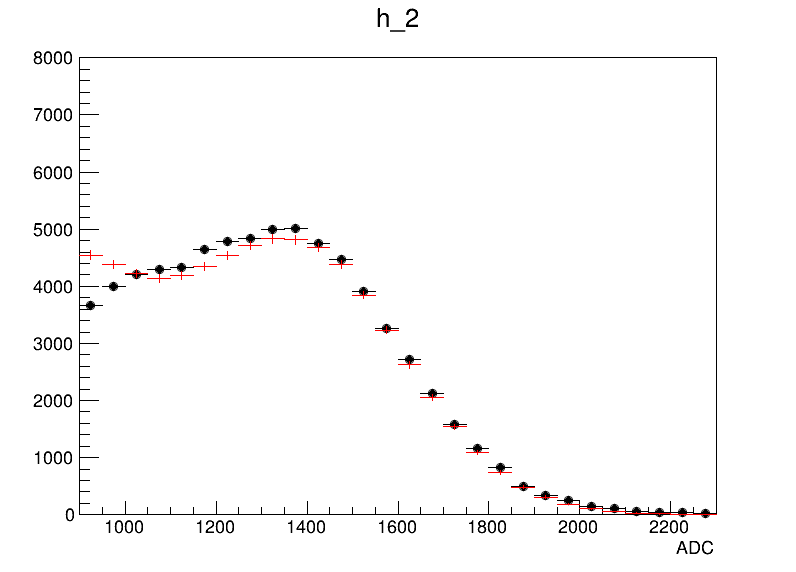

In [14]:
h_fit=smeared_scaled(fft_digi_ori,h_2,ranges['norm']['ini'],ranges['scale']['ini'],ranges['smear']['ini'])
R.gStyle.SetOptStat(0)
h_2.SetStats(0)
h_2.Draw('PE')
h_2.SetMarkerStyle(20)
h_2.SetMarkerSize(1.2)
h_2.SetMarkerColor(R.kBlack)
h_2.SetLineColor(R.kBlack)
h_fit.Draw('PSAME')
h_fit.SetMarkerColor(R.kRed)
h_fit.SetLineColor(R.kRed)
#h_ori.Draw('SAME')
h_2.SetMaximum(h_2.GetMaximum()*1.6)
h_2.GetXaxis().SetRangeUser(minX,maxX)
h_2.GetXaxis().SetTitle('ADC')
c1.Draw()

In [ ]:
#scan
tval={}
min_values=[99999.]
tolerance=1
min_diff=99999.
iter=0

watch=R.TStopwatch()
while (abs(min_diff)>tolerance):
    watch.Start()
    for ipar,(par,par_range) in enumerate(ranges.items()):
        #reinit
        minG[par].Clear()
        for ini_par in ranges:
            tval[ini_par]=init_values[ini_par]
        for ival,a in enumerate(np.arange(par_range['ini']-5*par_range['step'],par_range['ini']+5*par_range['step'],par_range['step'])):
            tval[par]=a
            val=chi2_func(tval['norm'],tval['scale'],tval['smear'])
            print(iter,par,ival,tval,val)
            minG[par].SetPoint(ival,a,val)
        minG[par].Fit('pol2')
    for par in ranges:
        init_values[par]=minG[par].GetFunction("pol2").GetMinimumX()
    min_values.append(chi2_func(init_values['norm'],init_values['scale'],init_values['smear']))
    min_diff=min_values[-1]-min_values[-2]
    watch.Stop()
    print("=====> ",iter,min_values[-1],min_diff,init_values)
    watch.Print()
    iter+=1

0 norm 0 {'norm': 5.5, 'scale': 0.84, 'smear': 175} 48.59972329544731
0 norm 1 {'norm': 5.6, 'scale': 0.84, 'smear': 175} 38.59740824657307
0 norm 2 {'norm': 5.699999999999999, 'scale': 0.84, 'smear': 175} 28.20663541542983
0 norm 3 {'norm': 5.799999999999999, 'scale': 0.84, 'smear': 175} 25.620348515804267
0 norm 4 {'norm': 5.899999999999999, 'scale': 0.84, 'smear': 175} 25.080199853344876
0 norm 5 {'norm': 5.999999999999998, 'scale': 0.84, 'smear': 175} 16.957119400342176
0 norm 6 {'norm': 6.099999999999998, 'scale': 0.84, 'smear': 175} 19.054318066040555
0 norm 7 {'norm': 6.1999999999999975, 'scale': 0.84, 'smear': 175} 19.418495167182076
0 norm 8 {'norm': 6.299999999999997, 'scale': 0.84, 'smear': 175} 22.828317009142022
0 norm 9 {'norm': 6.399999999999997, 'scale': 0.84, 'smear': 175} 25.293426639552226
0 scale 0 {'norm': 6.0, 'scale': 0.815, 'smear': 175} 88.6703646317949
0 scale 1 {'norm': 6.0, 'scale': 0.82, 'smear': 175} 60.70990165819554
0 scale 2 {'norm': 6.0, 'scale': 0.825

In [ ]:
for ipar,(par,par_range) in enumerate(ranges.items()):
    #minG[par].Draw("A*")
    #minG[par].Fit("pol2")
    min_x=minG[par].GetFunction("pol2").GetMinimumX()
    min_val=minG[par].GetFunction("pol2").GetMinimum()
    delta_plus=minG[par].GetFunction("pol2").GetX(min_val+1,min_x,min_x+5*ranges[par]['step'])-min_val
    delta_minus=min_val-minG[par].GetFunction("pol2").GetX(min_val+1,min_x-5*ranges[par]['step'],min_x)
    delta=(delta_plus+delta_minus)*0.5
    ranges[par]['min']=min_x
    ranges[par]['err']=delta

In [ ]:
h_fit_min=smeared_scaled(fft_digi_ori,h_2,ranges['norm']['min'],ranges['scale']['min'],ranges['smear']['min'])

In [ ]:
#Draw fit result
R.gStyle.SetOptTitle(0)

l=R.TLegend(0.1,0.7,0.4,0.86)
l.SetFillColorAlpha(0,0)
l.SetBorderSize(0)
l.SetTextSize(0.03)

h_2.Draw('PE')
l.AddEntry(h_2,'Target','P')

h_fit_min.Draw('PSAME')
h_fit_min.SetMarkerColor(R.kRed)
h_fit_min.SetMarkerStyle(24)
h_fit_min.SetMarkerSize(1.2)
#h_fit_min.SetLineColor(R.kRed)
l.AddEntry(h_fit_min,'Fit (Scaled + DCR Noise)','P')


#h_2.SetMaximum(4000)
h_2.GetXaxis().SetRangeUser(0.3*ps.GetPositionX()[n_peaks-1],2.2*ps.GetPositionX()[n_peaks-1])
#h_2.GetXaxis().SetTitle('ADC')
h_ori_c=h_ori.Clone('h_ori_c')
h_ori_c.Scale(h_2.GetEntries()/h_ori.GetEntries())
h_ori_c.Draw('SAME')
l.AddEntry(h_ori,'Original','PL')

t=R.TLatex()
t.SetTextSize(0.035)

results=R.TGraphErrors()
for ipar,(par,r) in enumerate(ranges.items()):
    t.DrawLatexNDC(0.6,0.825-ipar*0.04,"%s = %.3f #pm %.3f"%(par,r['min'],r['err']))
    results.SetPoint(ipar,ipar,r['min'])
    results.SetPointError(ipar,0,r['err'])
l.Draw()
c1.Draw()
for ext in ['.png','.pdf']:
    c1.SaveAs('results/fit_%s%s'%(run_target,ext))

fResults=R.TFile('results/fit_%s.root'%run_target,'RECREATE')
h_2.Write()
h_ori.Write()
h_fit_min.Write()
results.Write('fitResults')
fResults.Close()